In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [24]:
def load_qso_data(cls,cat_index, tag, rescale_flux):
    released_path = "XQ100_data/released/{0}_uvb-vis.txt".format(name) #2/11/21 changed released2 to released
    

In [57]:
path_to_cat = "XQ100_data/XQ-100_catalogue.txt"
catalog_table = pd.read_csv(path_to_cat,delim_whitespace=True,usecols=(3,6),
                                names = ("qso_name","redshifts"), comment='#')

df_tot = pd.DataFrame()
for i in range(len(catalog_table)):
    name = catalog_table["qso_name"].iloc[i]
    redshift = catalog_table["redshifts"].iloc[i]
    released_path = "XQ100_data/released/{0}_uvb-vis.txt".format(name)
    df_i = pd.read_csv(released_path, delim_whitespace=True, skiprows = 1,usecols=(0,1,2,3,4),
                                        names = ("wav", "flx", "ferr", "res","dloglam"))
    df_i["qso_idx"] = i
    df_i["redshift"] = redshift
    df_tot = pd.concat([df_tot,df_i])

In [74]:
df_tot["wav_rest"] = df_tot["wav"]/(1+df_tot["redshift"]) #.groupby("qso_idx")
df_tot[df_tot.qso_idx==0]

,wav,flx,ferr,res,dloglam,qso_idx,redshift,wav_rest
0,3099.92,-6.284100e-15,3.814920e-15,20.0,0.00003,0,3.508157,687.624677
1,3100.14,2.241830e-15,8.739010e-16,20.0,0.00003,0,3.508157,687.673477
2,3100.35,-3.037350e-16,8.631970e-16,20.0,0.00003,0,3.508157,687.720059
3,3100.57,-4.876140e-16,8.258850e-16,20.0,0.00003,0,3.508157,687.768860
4,3100.78,1.387870e-15,8.353000e-16,20.0,0.00003,0,3.508157,687.815442
...,...,...,...,...,...,...,...,...
17236,10196.00,3.224590e-16,2.578330e-17,11.0,0.00003,0,3.508157,2261.678109
17237,10196.70,3.828660e-16,2.603240e-17,11.0,0.00003,0,3.508157,2261.833383
17238,10197.40,2.558530e-16,2.532800e-17,11.0,0.00003,0,3.508157,2261.988657
17239,10198.10,2.994760e-16,2.593270e-17,11.0,0.00003,0,3.508157,2262.143932


(-1e-15, 1e-15)

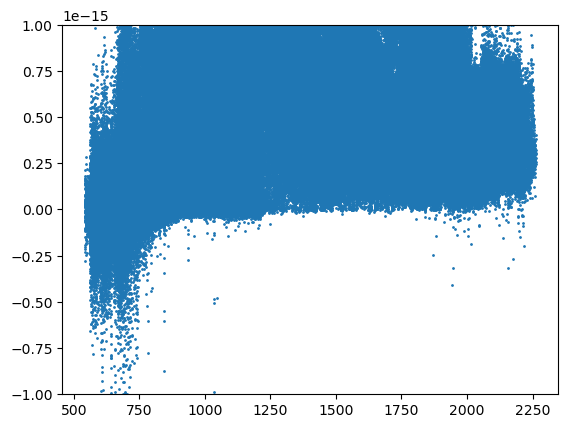

In [92]:
plt.scatter(df_tot.wav_rest, df_tot.flx,s=1)
plt.ylim(-1e-15,1e-15)

In [104]:
asdf = df_tot["wav_rest"].values
max(asdf[1:]-asdf[:-1]),np.mean(asdf[1:]-asdf[:-1])

(0.17745610900419706, 0.0006358417641920302)

In [88]:
df_tot.flx

0       -6.284100e-15
1        2.241830e-15
2       -3.037350e-16
3       -4.876140e-16
4        1.387870e-15
             ...     
17236    4.711240e-16
17237    6.075460e-16
17238    6.501080e-16
17239    6.133930e-16
17240    6.807590e-16
Name: flx, Length: 1724728, dtype: float64

In [82]:
# df_tot[df_tot.qso_idx==1]


In [72]:
# df_tot["wav_rest"],df_tot["flx"]

(array([15., 23.,  7.,  9.,  9., 15.,  9.,  8.,  4.,  1.]),
 array([3.508157 , 3.6289338, 3.7497106, 3.8704874, 3.9912642, 4.112041 ,
        4.2328178, 4.3535946, 4.4743714, 4.5951482, 4.715925 ]),
 <BarContainer object of 10 artists>)

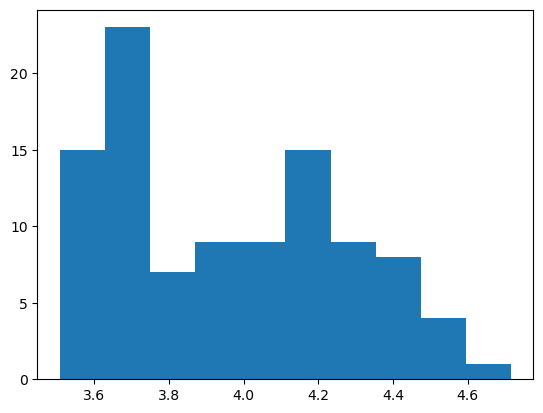

In [28]:
# plt.plot(df.wav, df.flx)
plt.hist(catalog_table["redshifts"].values)

In [37]:
redshifts = catalog_table["redshifts"].values
np.sum((redshifts>3.6)&(redshifts<3.8))

29